In [1]:
!pip install d2l

In [2]:
import d2l.torch as d2l

In [3]:
import torchvision
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import numpy as np

In [4]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = d2l.download_extract('pokemon')

In [5]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon = torchvision.datasets.ImageFolder(data_dir, transformer)
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

In [6]:
class G_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4,
                 strides=2, padding=1, **kwargs):
        nn.Module.__init__(self)
        self.conv2d_trans = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [7]:
g_blk = G_block(3,20)
x = torch.zeros((2,3,1,1))
g_blk = G_block(3,20,strides=1,padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

In [8]:
n_G = 64
net_G = nn.Sequential(
    G_block(10,n_G*8, strides=1, padding=0),
    G_block(n_G*8,n_G*4),
    G_block(n_G*4,n_G*2),
    G_block(n_G*2,n_G),
    nn.ConvTranspose2d(n_G,3,kernel_size=4, stride=2, padding=1, bias=False),
    nn.ReLU())

In [9]:
x = torch.zeros((1,10,1,1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

In [10]:
print(net_G)

Sequential(
  (0): G_block(
    (conv2d_trans): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (1): G_block(
    (conv2d_trans): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (2): G_block(
    (conv2d_trans): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (3): G_block(
    (conv2d_trans): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()

In [11]:
# Define discriminator
class D_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
        nn.Module.__init__(self)
        self.conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [12]:
n_D = 64
net_D = nn.Sequential(
          D_block(3,n_D),   # Output: (64, 32, 32)
          D_block(n_D,n_D*2),  # Output: (64 * 2, 16, 16)
          D_block(n_D*2,n_D*4),  # Output: (64 * 4, 8, 8)
          D_block(n_D*4,n_D*8),  # Output: (64 * 8, 4, 4)
          nn.Conv2d(n_D*8, 1, kernel_size=4, bias=False)
          )  # Output: (1, 1, 1)

In [13]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,1,1,1)) # ctx=X.ctx)
    zeros = torch.zeros((batch_size,1,1,1)) # ctx=X.ctx)
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones) + loss(fake_Y, zeros)) / 2
    loss_D.backward()
    with torch.no_grad():
        trainer_D.step()
    return float(loss_D.sum())

In [14]:
def update_G(Z, net_D, net_G, loss, trainer_G):  #@save
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,1,1,1)) # ctx=Z.ctx)
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones)
    loss_G.backward()
    with torch.no_grad():
        trainer_G.step()
    return float(loss_G.sum())

In [15]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = torch.nn.BCEWithLogitsLoss()
    # net_D.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    # net_G.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    for epoch in range(1, num_epochs + 1):
        print('Epoch',epoch)
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            print('Processing batch')
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            # X, Z = X.as_in_ctx(device), Z.as_in_ctx(device),
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}')
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

In [16]:
latent_dim, lr, num_epochs = 10, 0.005, 1 # 20
print('Starting training')
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

Starting training
Epoch 1


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Processing batch
Processing batch
Processing batch


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Processing batch
Processing batch
Processing batch


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch


KeyboardInterrupt: ignored

In [17]:
Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1)) # ct          x=device)
fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
imgs = np.concatenate(
             [np.concatenate([fake_x[i * 7 + j].detach().numpy() for j in range(7)], axis=1)
              for i in range(len(fake_x)//7)], axis=0)

np.save('imgs.npy',imgs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


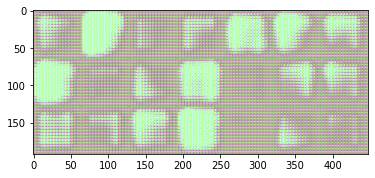

In [19]:
plt.imshow(imgs)